In [100]:
from rdkit import Chem
from matplotlib import pyplot as plt
import networkx as nx
from IPython.display import display

## Loading a molecule from a SMILES string

### Load the SMILS and print the 2D chemical structure

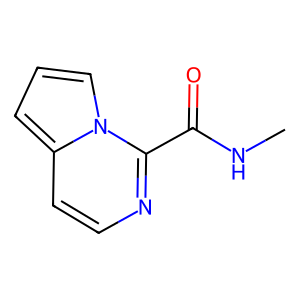

In [101]:
smiles = 'CNC(=O)c1nccc2cccn12'
molecule = Chem.MolFromSmiles(smiles)
from rdkit.Chem import Draw
img = Draw.MolToImage(molecule)
display(img)

You can also show the chemical with the hydrogens attached as this isnt done by default.

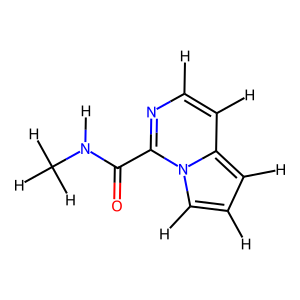

In [102]:
molecule_h = Chem.AddHs(molecule)
img_h = Draw.MolToImage(molecule_h)
display(img_h)

### Chemical Highlighting

Images of chemical structures with highlighted atoms can also be generated using the `Draw` module from RDKit.

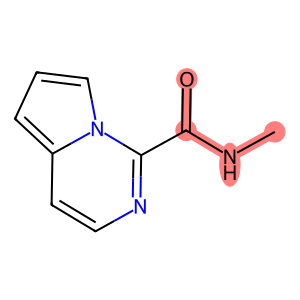

In [103]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

patt = Chem.MolFromSmarts('CNC(=O)')

hit_ats = molecule.GetSubstructMatch(patt)
hit_bonds = []
if hit_ats:
    for bond in patt.GetBonds():
        aid1 = hit_ats[bond.GetBeginAtomIdx()]
        aid2 = hit_ats[bond.GetEndAtomIdx()]
        hit_bonds.append(molecule.GetBondBetweenAtoms(aid1, aid2).GetIdx())

d = rdMolDraw2D.MolDraw2DSVG(300, 300)
d.DrawMolecule(molecule, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
d.FinishDrawing()
SVG(d.GetDrawingText())


# Graphs and Geometry

### 2D depiction coordinates

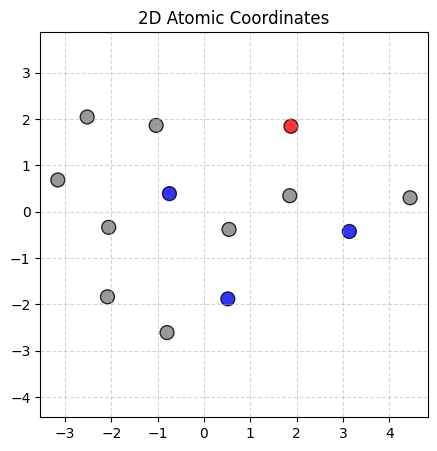

In [104]:
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def generate_structure_depiction(mol, template_mol=None):
    """
    Generates 2D coordinates for a molecule, optionally matching a template structure.
    Returns the conformer coordinates.
    """
    # Compute 2D coordinates for the molecule
    AllChem.Compute2DCoords(mol)
    
    # If a template is provided, align the molecule to the template
    if template_mol is not None:
        AllChem.GenerateDepictionMatching2DStructure(mol, template_mol)
        
    # Extract coordinates
    conformer = mol.GetConformer()
    coords = conformer.GetPositions()
    return coords

coords = generate_structure_depiction(molecule)

# Define atom colors (CPK-like)
cpk_colors = {
    'C': 'gray',
    'O': 'red',
    'N': 'blue',
    'S': 'yellow',
    'P': 'orange',
    'F': 'green',
    'Cl': 'green',
    'Br': 'darkred',
    'I': 'purple',
    'H': 'lightgray'
}

# Get colors for each atom in the molecule
colors = [cpk_colors.get(atom.GetSymbol(), 'black') for atom in molecule.GetAtoms()]

# Visualize the atomic positions
plt.figure(figsize=(5, 5))
plt.scatter(coords[:, 0], coords[:, 1], s=100, c=colors, alpha=0.8, edgecolors='black')
plt.title("2D Atomic Coordinates")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

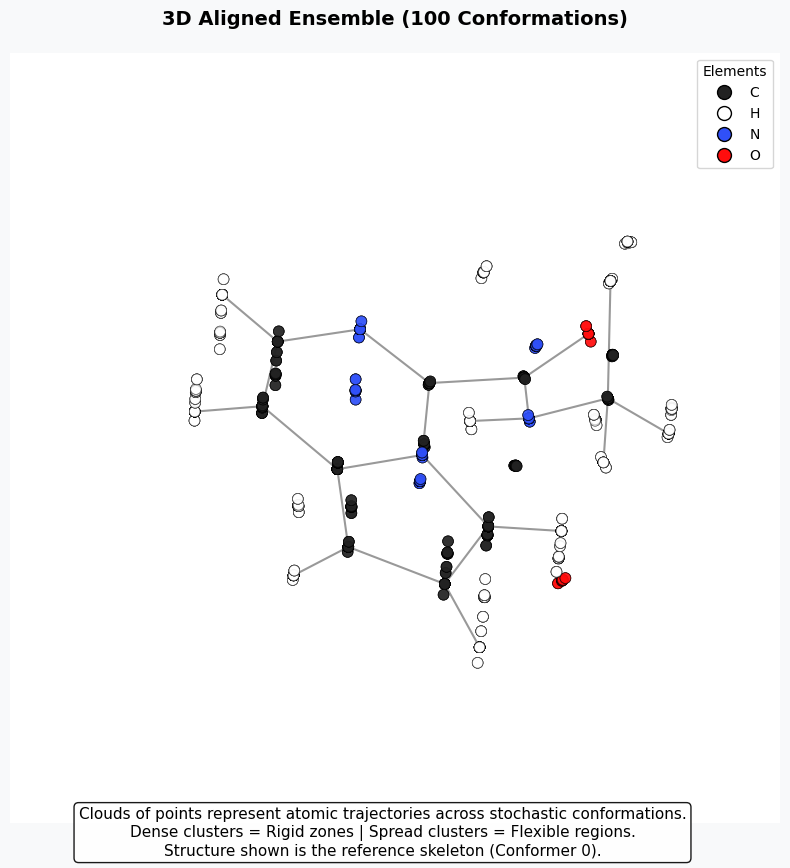

In [105]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define the molecule
smiles = "CNC(=O)c1nccc2cccn12"
molecule = Chem.MolFromSmiles(smiles)

def generate_3d_ensemble(mol, num_confs=100, seed=42):
    """Generates an ensemble of 3D conformations and aligns them."""
    mH = Chem.AddHs(mol)
    params = AllChem.ETKDGv3()
    params.randomSeed = seed
    
    AllChem.EmbedMultipleConfs(mH, numConfs=num_confs, params=params)
    AllChem.MMFFOptimizeMoleculeConfs(mH)
    rdMolAlign.AlignMolConformers(mH)
    return mH

# Generate the aligned ensemble
molecule_3d = generate_3d_ensemble(molecule)

# Element-to-color mapping (Standard CPK colors)
cpk_colors = {
    'C': '#222222', 'O': '#FF0D0D', 'N': '#3050F8', 
    'H': '#FFFFFF', 'S': '#FFFF30', 'P': '#FF8000',
}

fig = plt.figure(figsize=(10, 10), facecolor='#f8f9fa')
ax = fig.add_subplot(111, projection='3d')

# 1. Plot the skeletal bonds for the reference conformer
conf0 = molecule_3d.GetConformer(0)
for bond in molecule_3d.GetBonds():
    idx1, idx2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    p1, p2 = conf0.GetAtomPosition(idx1), conf0.GetAtomPosition(idx2)
    ax.plot([p1.x, p2.x], [p1.y, p2.y], [p1.z, p2.z], 
            color='black', alpha=0.4, linewidth=1.5, zorder=1)

# 2. Plot Atomic clouds across the ensemble
atoms = molecule_3d.GetAtoms()
seen_symbols = set()
for i, atom in enumerate(atoms):
    symbol = atom.GetSymbol()
    color = cpk_colors.get(symbol, '#CCCCCC')
    
    # Collect positions for this specific atom across all conformers
    atom_coords = np.array([conf.GetAtomPosition(i) for conf in molecule_3d.GetConformers()])
    
    # Plot the cloud
    ax.scatter(atom_coords[:, 0], atom_coords[:, 1], atom_coords[:, 2], 
               alpha=0.35, c=color, edgecolors='black', s=60, 
               linewidth=0.5, zorder=2)
    seen_symbols.add(symbol)

# 3. Add a Custom Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=s, 
                          markerfacecolor=cpk_colors.get(s, '#CCC'), 
                          markersize=10, markeredgecolor='k') for s in sorted(list(seen_symbols))]
ax.legend(handles=legend_elements, title="Elements", loc='upper right', frameon=True)

# 4. Final Polish
ax.set_title(f"3D Aligned Ensemble ({molecule_3d.GetNumConformers()} Conformations)", 
             fontsize=14, fontweight='bold', pad=20)
ax.view_init(elev=25, azim=35) # Better viewing angle
ax.set_axis_off() # Cleaner look without the box grid

explanation = (
    "Clouds of points represent atomic trajectories across stochastic conformations.\n"
    "Dense clusters = Rigid zones | Spread clusters = Flexible regions.\n"
    "Structure shown is the reference skeleton (Conformer 0)."
)
plt.figtext(0.5, 0.08, explanation, wrap=True, horizontalalignment='center', 
            fontsize=11, fontname='sans-serif', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.show()


## 3D Plotting

In [106]:
import py3Dmol
from rdkit import Chem

view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(molecule), 'mol')
view.setStyle({'stick': {}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Graph Traversal

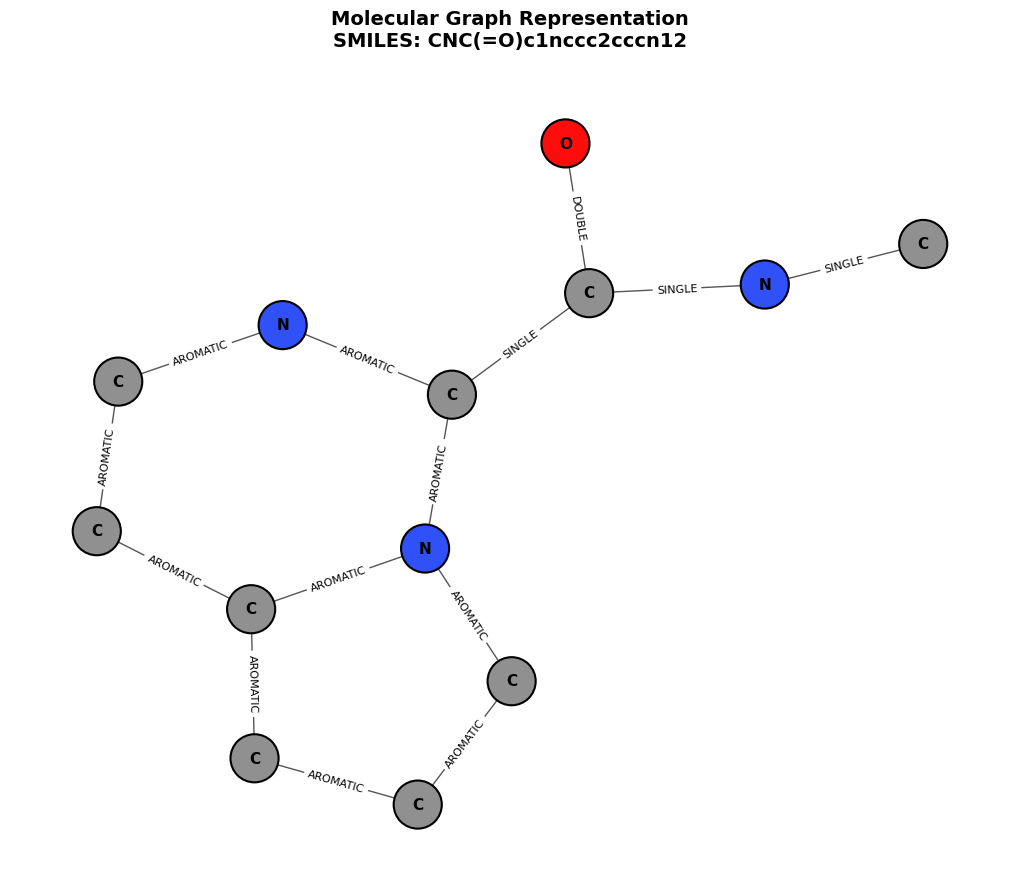

In [107]:
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem

def mol_to_nx(mol):
    """Converts an RDKit molecule object into a NetworkX graph with atom and bond metadata."""
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   symbol=atom.GetSymbol(),
                   atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType().name)
    return G

# CPK Color Palette for common atoms
CPK_COLORS = {
    'C': '#909090', 'O': '#FF0D0D', 'N': '#3050F8', 
    'S': '#FFFF30', 'P': '#FF8000', 'F': '#90E050', 
    'Cl': '#1FF01F', 'Br': '#A62929', 'I': '#940094',
    'H': '#FFFFFF'
}

G = mol_to_nx(molecule)
pos = nx.kamada_kawai_layout(G)  # Better layout for molecular structures
symbols = nx.get_node_attributes(G, 'symbol')
node_colors = [CPK_COLORS.get(symbols[n], '#00D1FF') for n in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(
    G, pos, 
    labels=symbols, 
    with_labels=True, 
    node_color=node_colors, 
    node_size=1200, 
    font_size=11, 
    font_weight='bold',
    edge_color='#555555',
    linewidths=1.5,
    edgecolors='black'
)

# Add bond type labels to edges
edge_labels = nx.get_edge_attributes(G, 'bond_type')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title(f"Molecular Graph Representation\nSMILES: {smiles}", fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.show()



In [108]:
nodes = []

for atom in molecule.GetAtoms():
    _ = [
        atom.GetAtomicNum(),
        atom.GetFormalCharge(),
        int(atom.GetIsAromatic()),
        int(atom.GetAtomicNum() == 1),
        int(atom.GetAtomicNum() in [9, 17, 35, 53]),
        atom.GetMass(),
        atom.GetTotalNumHs(),
        atom.GetIsotope(),
        atom.GetTotalDegree(),
        atom.GetTotalValence(),
        int(atom.GetChiralTag()),
        int(atom.GetHybridization()),
        atom.GetIdx(),
        [neighbor.GetIdx() for neighbor in atom.GetNeighbors()]
    ]
    nodes.append(_)

nodes

[[6, 0, 0, 0, 0, 12.011, 3, 0, 4, 4, 0, 4, 0, [1]],
 [7, 0, 0, 0, 0, 14.007, 1, 0, 3, 3, 0, 3, 1, [0, 2]],
 [6, 0, 0, 0, 0, 12.011, 0, 0, 3, 4, 0, 3, 2, [1, 3, 4]],
 [8, 0, 0, 0, 0, 15.999, 0, 0, 1, 2, 0, 3, 3, [2]],
 [6, 0, 1, 0, 0, 12.011, 0, 0, 3, 4, 0, 3, 4, [2, 5, 12]],
 [7, 0, 1, 0, 0, 14.007, 0, 0, 2, 3, 0, 3, 5, [4, 6]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 6, [5, 7]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 7, [6, 8]],
 [6, 0, 1, 0, 0, 12.011, 0, 0, 3, 4, 0, 3, 8, [7, 9, 12]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 9, [8, 10]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 10, [9, 11]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 11, [10, 12]],
 [7, 0, 1, 0, 0, 14.007, 0, 0, 3, 3, 0, 3, 12, [11, 4, 8]]]

In [109]:
nodes

[[6, 0, 0, 0, 0, 12.011, 3, 0, 4, 4, 0, 4, 0, [1]],
 [7, 0, 0, 0, 0, 14.007, 1, 0, 3, 3, 0, 3, 1, [0, 2]],
 [6, 0, 0, 0, 0, 12.011, 0, 0, 3, 4, 0, 3, 2, [1, 3, 4]],
 [8, 0, 0, 0, 0, 15.999, 0, 0, 1, 2, 0, 3, 3, [2]],
 [6, 0, 1, 0, 0, 12.011, 0, 0, 3, 4, 0, 3, 4, [2, 5, 12]],
 [7, 0, 1, 0, 0, 14.007, 0, 0, 2, 3, 0, 3, 5, [4, 6]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 6, [5, 7]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 7, [6, 8]],
 [6, 0, 1, 0, 0, 12.011, 0, 0, 3, 4, 0, 3, 8, [7, 9, 12]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 9, [8, 10]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 10, [9, 11]],
 [6, 0, 1, 0, 0, 12.011, 1, 0, 3, 4, 0, 3, 11, [10, 12]],
 [7, 0, 1, 0, 0, 14.007, 0, 0, 3, 3, 0, 3, 12, [11, 4, 8]]]

In [110]:
edges = []

for bond in molecule.GetBonds():
    _ = [
        bond.GetBeginAtomIdx(),
        bond.GetEndAtomIdx(),
        int(bond.GetBondType())
    ]
    edges.append(_)

edges

[[0, 1, 1],
 [1, 2, 1],
 [2, 3, 2],
 [2, 4, 1],
 [4, 5, 12],
 [5, 6, 12],
 [6, 7, 12],
 [7, 8, 12],
 [8, 9, 12],
 [9, 10, 12],
 [10, 11, 12],
 [11, 12, 12],
 [12, 4, 12],
 [12, 8, 12]]